In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Data Pre-processing

The data consists of the artifactual variant calls that differ from the GIAB high confidence calls produced by the NGS pipeline.

Below define a dictionary of your XRR accessions and their associated class. Here, 0 = hybrid capture, and 1 = PCR

In [10]:
srx_dict = {'ERR1831349': 0, 'ERR1905889': 0, 'ERR1905890': 0, 'ERR1831350': 0, 
            'ERR032972': 1, 'SRR1620964': 1, 'ERR1679737': 1, 'ERR032971': 1}

Import each tab_delimited artifacts file as a dataframe and add the associated class as a column. Append all dataframes together.

In [11]:
data = pd.DataFrame(columns = ['#CHROM\tPOS\tREF\tALT', 'y'])
directory = '/home/ztom/pipeline/data_archive/12_01_2020/artifacts/all'
for filename in os.listdir(directory):
    #do not parse tabs so that data is read in as one column
    df = pd.read_csv(os.path.join(directory,filename), header=0)
    df = df.dropna()
    #remove duplicate rows
    length1 = len(df)
    df = df.drop_duplicates()
    length2 = len(df)
    print(length1, length2)
    #add prediction class class column
    df['y'] = srx_dict[filename.split('_')[0]]
    print(df.shape)
    print(list(df.columns))
    data = pd.concat([data, df], ignore_index=True)
print(data.shape)


22183 21610
(21610, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
62970 60994
(60994, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
44695 43233
(43233, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
73705 72198
(72198, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
5377 5345
(5345, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
483 481
(481, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
25905 25205
(25205, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
71257 69870
(69870, 2)
['#CHROM\tPOS\tREF\tALT', 'y']
(298936, 2)


Clean up the data for readability

In [12]:
data = data.replace({'\t':'/'}, regex=True)
data.columns = ['CHROM_POS_REF_ALT', 'y']
data.head()

,CHROM_POS_REF_ALT,y
0,chr10/169950/CACCAA/CA/,0
1,chr10/170475/AAATGAATGA/AAATGA/,0
2,chr10/217125/CT/CTTT/,0
3,chr10/239537/TTGT/TTGTGT/,0
4,chr10/277066/GTTTT/GTTTTT/,0


#### Input variables

1 - chromosome / position / reference allele / artifact allele (categorical)

#### Predict variable (desired target):

y - what type of enrichment was performed? Hybrid capture or PCR? (binary: 1 / 0)

## Data exploration

### Evaluate Redundancy

Every sequence read run consists of a set of mostly unique artifacts. Between sequencing runs, we want to see some repeat artifacts to indicate a pattern that can be potentially attributed to sample manipulation / library construction protocol variables. The fraction of repeat artifacts for this dataset is seen below:

In [13]:
print('Number of unique artifacts: ', data['CHROM_POS_REF_ALT'].unique().size)
print('Percentage of repeat artifacts: {:.2f}'.format(1 - data['CHROM_POS_REF_ALT'].unique().size/data.shape[0]))

Number of unique artifacts:  192157
Percentage of repeat artifacts: 0.36


### Evaluate Balance

We want a relatively equal proportion of classes in the dataset. If there is an imbalance, oversmapling can be conducted.

In [14]:
data['y'].value_counts()

0    151042
1    147894
Name: y, dtype: int64

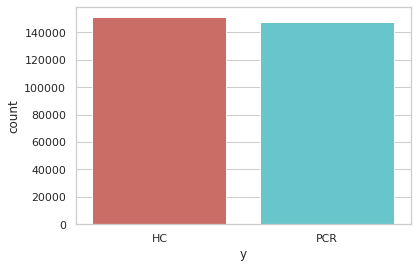

In [15]:
sns.countplot(x='y',data=data, palette='hls')
plt.xticks(np.arange(2), ['HC','PCR'])
plt.show()

In [16]:
count_HC = len(data[data['y']==0])
count_PCR = len(data[data['y']==1])
pct_of_HC = count_HC/(count_HC+count_PCR)
print("percentage of HC is {:.2f}".format(pct_of_HC*100))
pct_of_PCR = count_PCR/(count_HC+count_PCR)
print("percentage of PCR is {:.2f}".format(pct_of_PCR*100))

percentage of HC is 50.53
percentage of PCR is 49.47


The classes are well balanced between hybrid capture and polymerase chain reaction.

### Data Visualizations

Let's take a look at the n most frequent artifacts found in the dataset to see if any are a good predictor of the outcome variable. Operating under the assumption that the more frequently an artifacts appears, the more likely it has a specific cause. The maximum number of times an artifact will appear is the number of sequencing runs used.

In [17]:
n = 20
print(data['CHROM_POS_REF_ALT'].value_counts()[:n])
most_frequent_artifact = data['CHROM_POS_REF_ALT'].value_counts()[:n].index.tolist()
mfas = data[data['CHROM_POS_REF_ALT'].isin(most_frequent_artifact)].CHROM_POS_REF_ALT
mfcs = data[data['CHROM_POS_REF_ALT'].isin(most_frequent_artifact)].y
#shorten the artifact names for plot readability
mfas = mfas.apply(lambda x: x[:14])

chr6/158078065/GTT/GTTT/                                                7
chr5/171899699/AT/ATT/                                                  7
chr1/80496448/AAA/AAACAA/                                               7
chr10/93057050/GAAA/GAAAA/                                              7
chr18/63498856/AGTGTGT/AGTGTGTGT/                                       7
chr6/89200966/CTGT/CTGTGT/                                              6
chr6/24479797/CATATATATATAT/CATATATATAT/                                6
chr6/126008837/ACCCC/ACCCCC/                                            6
chr15/58802105/CAAA/CAAAA/                                              6
chr1/7787302/CTTTTTT/CTTTTTTT/                                          6
chr20/35501830/CCTCTCT/CCTCT/                                           6
chr11/114971423/ATCTCTCTCTCTCTCTCTCTCTC/ATCTCTCTCTCTCTCTCTCTCTCTCTC/    6
chr10/123041039/ATTTTTT/ATTTTT/                                         6
chr1/210418398/TGGGGGG/TGGGGG/        

Text(0, 0.5, 'Frequency')

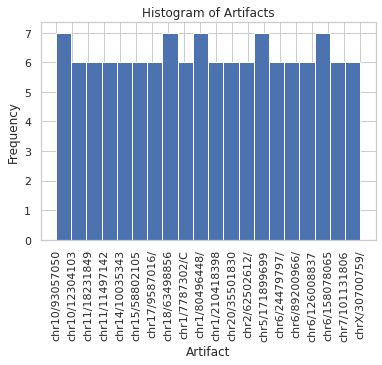

In [18]:
plt.hist(mfas, 20)
plt.xticks(rotation='vertical')
plt.title('Histogram of Artifacts')
plt.xlabel('Artifact')
plt.ylabel('Frequency')

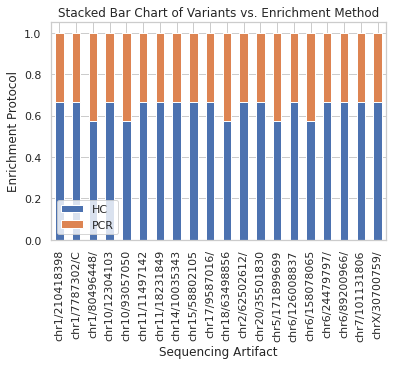

In [19]:
table=pd.crosstab(mfas,mfcs)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Variants vs. Enrichment Method')
plt.xlabel('Sequencing Artifact')
plt.ylabel('Enrichment Protocol')
plt.legend(['HC', 'PCR'], loc='lower left')
#plt.figure(figsize=(20,10))

Based on the results, these artifacts appear to be a good predictor of enrichment protocol step, with hybrid capture producing the majority of frequently occuring artifacts.

## Target Encoding

Because there are 192,157 unique categorical values for the artifact feature, one-hot encoding is not feasible. Attepts to produce dummy variables with one-hot encoding results in kernel crash likely due to running out of memory. Thus, target encoding is used.

In [20]:
encoder = TargetEncoder()
data['CHROM_POS_REF_ALT Encoded'] = encoder.fit_transform(data['CHROM_POS_REF_ALT'], data['y'])
    
print(data.head())
data_final=data[['CHROM_POS_REF_ALT Encoded','y']]
data_final.columns.values

/home/ztom/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


                 CHROM_POS_REF_ALT  y  CHROM_POS_REF_ALT Encoded
0          chr10/169950/CACCAA/CA/  0                   0.494735
1  chr10/170475/AAATGAATGA/AAATGA/  0                   0.133055
2            chr10/217125/CT/CTTT/  0                   0.261607
3        chr10/239537/TTGT/TTGTGT/  0                   0.058974
4       chr10/277066/GTTTT/GTTTTT/  0                   0.023463


array(['CHROM_POS_REF_ALT Encoded', 'y'], dtype=object)

## Logistic Regression Model Fitting

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X = data_final.loc[:, 'CHROM_POS_REF_ALT Encoded']
y = data_final.loc[:, 'y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
#reshape data because we have one feature
X_train_reshaped = X_train.values.reshape(-1, 1)
X_test_reshaped = X_test.values.reshape(-1, 1)

logreg = LogisticRegression()
logreg.fit(X_train_reshaped, y_train)

LogisticRegression()

In [22]:
y_pred = logreg.predict(X_test_reshaped)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_reshaped, y_test)))

Accuracy of logistic regression classifier on test set: 0.70


## Results Analysis

### Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[21858 23475]
 [ 3741 40607]]


These results tell us that we have 21858+40607 correct predictions and 3741+23475 incorrect predictions.

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.48      0.62     45333
           1       0.63      0.92      0.75     44348

    accuracy                           0.70     89681
   macro avg       0.74      0.70      0.68     89681
weighted avg       0.74      0.70      0.68     89681



#### Interpretation:

Of the entire test set, 70% of the predicted enrichment steps were the enrichment step associated with the corresponding artifact.

### ROC Curve

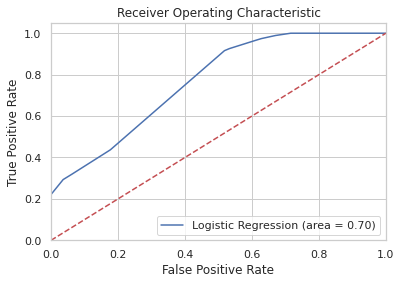

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test_reshaped))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_reshaped)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The Area Under Curve (AUC) is within the 0.7 - 0.8 range, so not outstanding but acceptable.